EXAMPLE 1: Simple 3-Variable QUBO Problem
QUBO Matrix Q:
[[-5  4  8]
 [ 0 -3  0]
 [ 0  0 -8]]

Ising Hamiltonian (num qubits: 3):
SparsePauliOp(['ZII', 'IZI', 'IIZ', 'ZZI', 'ZII', 'IZI', 'ZIZ', 'ZII', 'IIZ', 'III'],
              coeffs=[ 2.5+0.j,  1.5+0.j,  4. +0.j,  1. +0.j, -1. +0.j, -1. +0.j,  2. +0.j,
 -2. +0.j, -2. +0.j, -5. +0.j])

Solving with VQE...
Beginning optimization with: COBYLA
Optimization finished

Sampling optimized state...

Top 3 measurement results:
  1. |011⟩: prob=0.9997, x=[0 1 1], objective=-11.00
  2. |101⟩: prob=0.0002, x=[1 0 1], objective=-5.00
  3. |110⟩: prob=0.0001, x=[1 1 0], objective=-4.00

Best solution found: x = [0 1 1]
Objective value: -11.00

Verification (brute force search):
Optimal solution: x = [0 1 1], objective = -11.00


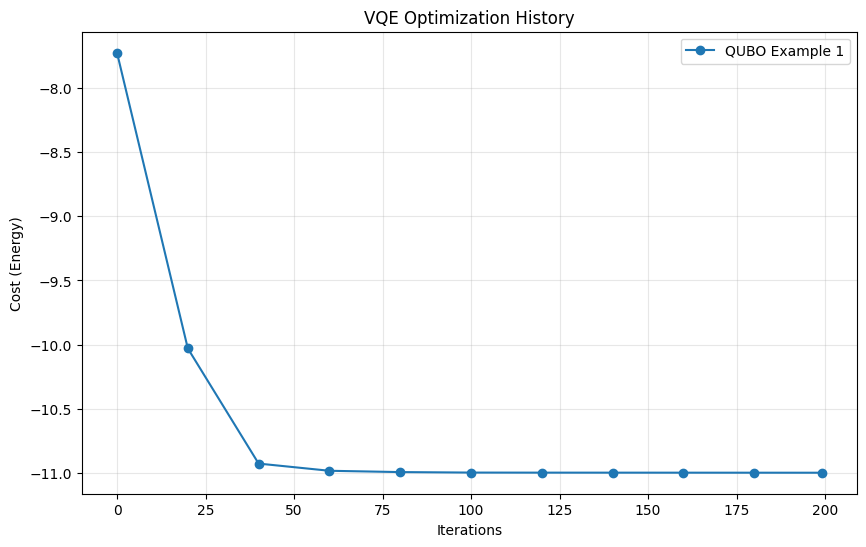

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from QUBO_VQE import VQESolver


def qubo_to_ising_hamiltonian(Q):
    """
    Convert a QUBO matrix Q to an Ising Hamiltonian.
    
    QUBO: minimize x^T Q x, where x ∈ {0,1}^n
    Ising: minimize sum_ij J_ij Z_i Z_j + sum_i h_i Z_i
    
    Conversion: x_i = (1 - Z_i)/2
    
    Args:
        Q: QUBO matrix (n x n numpy array)
        
    Returns:
        SparsePauliOp representing the Ising Hamiltonian
    """
    n = Q.shape[0]
    
    # Build Pauli operator list
    pauli_list = []
    constant = 0.0
    
    # Diagonal terms: Q_ii * x_i = Q_ii * (1 - Z_i)/2
    for i in range(n):
        if Q[i, i] != 0:
            # Linear term: -Q_ii/2 * Z_i
            pauli_str = ['I'] * n
            pauli_str[i] = 'Z'
            pauli_list.append((''.join(pauli_str), -Q[i, i] / 2))
            
            # Constant term: Q_ii/2
            constant += Q[i, i] / 2
    
    # Off-diagonal terms: Q_ij * x_i * x_j = Q_ij * (1-Z_i)(1-Z_j)/4
    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0 or Q[j, i] != 0:
                Q_ij = Q[i, j] + Q[j, i]  # Symmetrize
                
                # ZZ term: Q_ij/4 * Z_i Z_j
                pauli_str = ['I'] * n
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append((''.join(pauli_str), Q_ij / 4))
                
                # Z_i term: -Q_ij/4 * Z_i
                pauli_str = ['I'] * n
                pauli_str[i] = 'Z'
                pauli_list.append((''.join(pauli_str), -Q_ij / 4))
                
                # Z_j term: -Q_ij/4 * Z_j
                pauli_str = ['I'] * n
                pauli_str[j] = 'Z'
                pauli_list.append((''.join(pauli_str), -Q_ij / 4))
                
                # Constant: Q_ij/4
                constant += Q_ij / 4
    
    # Add constant term as identity
    if constant != 0:
        pauli_list.append(('I' * n, constant))
    
    return SparsePauliOp.from_list(pauli_list)


def ising_to_binary(bitstring):
    """
    Convert Ising solution (0/1 bitstring) to binary solution.
    In Qiskit measurement, |0⟩ corresponds to Z=+1 and |1⟩ to Z=-1
    For QUBO: x_i = (1 - Z_i)/2, so x_i = 1 when Z_i = -1 (measured as |1⟩)
    
    Args:
        bitstring: string of '0' and '1'
        
    Returns:
        numpy array of binary values
    """
    # The bitstring from measurement is already in the correct format:
    # '1' means x_i = 1, '0' means x_i = 0
    return np.array([int(b) for b in bitstring])


def evaluate_qubo(Q, x):
    """
    Evaluate QUBO objective: x^T Q x
    
    Args:
        Q: QUBO matrix
        x: binary solution vector
        
    Returns:
        Objective value
    """
    return x.T @ Q @ x


# ============================================================================
# EXAMPLE 1: Simple 3-variable QUBO
# ============================================================================
print("=" * 70)
print("EXAMPLE 1: Simple 3-Variable QUBO Problem")
print("=" * 70)

# Define QUBO matrix
# minimize: -5*x0 - 3*x1 - 8*x2 + 4*x0*x1 + 8*x0*x2
Q1 = np.array([
    [-5,  4,  8],
    [ 0, -3,  0],
    [ 0,  0, -8]
])

print("QUBO Matrix Q:")
print(Q1)

# Convert to Ising Hamiltonian
hamiltonian1 = qubo_to_ising_hamiltonian(Q1)
print(f"\nIsing Hamiltonian (num qubits: {hamiltonian1.num_qubits}):")
print(hamiltonian1)

# Solve with VQE
vqe1 = VQESolver()
vqe1.set_hamiltonian(hamiltonian1)
vqe1.set_ansatz_type('RealAmplitudes', reps=3)

print(f"\nSolving with VQE...")
optimal_params1 = vqe1.solve(
    maxiter=200,
    optimizer='COBYLA',
    callback_step_size=20
)

# Get the solution
print("\nSampling optimized state...")
stats1 = vqe1.sample_circuit(optimal_params1)

# Find best solution
sorted_stats1 = sorted(stats1.items(), key=lambda x: x[1], reverse=True)
best_bitstring1 = bin(sorted_stats1[0][0])[2:].zfill(3)
best_solution1 = ising_to_binary(best_bitstring1)

print(f"\nTop 3 measurement results:")
for i, (state, prob) in enumerate(sorted_stats1[:3]):
    bitstring = bin(state)[2:].zfill(3)
    solution = ising_to_binary(bitstring)
    obj_value = evaluate_qubo(Q1, solution)
    print(f"  {i+1}. |{bitstring}⟩: prob={prob:.4f}, x={solution}, objective={obj_value:.2f}")

print(f"\nBest solution found: x = {best_solution1}")
print(f"Objective value: {evaluate_qubo(Q1, best_solution1):.2f}")

# Verify by brute force
print("\nVerification (brute force search):")
best_obj = float('inf')
best_x = None
for i in range(2**3):
    x = np.array([int(b) for b in bin(i)[2:].zfill(3)])
    obj = evaluate_qubo(Q1, x)
    if obj < best_obj:
        best_obj = obj
        best_x = x
print(f"Optimal solution: x = {best_x}, objective = {best_obj:.2f}")

vqe1.plot_optimization_history(legend='QUBO Example 1')

In [12]:
import math

def iqft(qc, qr, qubits_list = None, swaps = False):
    '''
    Append the Inverse QFT (IQFT) operator to a quantum circuit qc

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the IQFT
        - qubits_list (int[]): list that indicates the order of the qubits. If None we select the natural order (From zero to the amount of qubits in qr)
        - swaps (boolean): If True then we perform swaps operations before the IQFT

    Returns: 
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)


    if swaps:
        for i in range(int(n/2)):
            qc.swap(qr[qubits_list[i]], qr[qubits_list[(n-1)-i]])


    for i in range(n):

        k = (n - 1) - i
        for j in range(k + 1, n):
            phase = - 2 * math.pi / (2**(2 + j - (k + 1)))
            qc.cp(phase, qr[qubits_list[j]], qr[qubits_list[k]])

        qc.h(qubits_list[k])

    
    

    return


def controlled_u(qc, qr, control, exponent): 
    '''
    Append the gate U^exponent on the register qr controlled by the qubit control. Where U = Rz(4pi/(3m))

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit 
        - qr (QuantumRegister): Qiskit Quantum Register where the U^exponent gate is applied
        - control (int:QuantumRegister[i]): Control Qubit
        - exponent (int)

    Returns:
        - None
    '''

    m = len(qr)

    for i in range(m):
        qc.crz(exponent * (4*math.pi / (3 * m)), control, qr[i])

    return



def phase_estimation(qc, pr, sc, controlled_u):
    '''
    Append the Phase estimation procedure to the quantum circuit qc

    Agrs:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - pr (QuantumRegister): Principal register. First register in the algorithm
        - sc (QuantumRegister): Second Register.
        - controlled_u (Function): Function that Appends the controlled U^exponent gate to the circuit  

    Returns:
        None
    '''

    t = len(pr)

    for i in range(t):
        controlled_u(qc, sc, pr[(t-1) - i], 2**i)

    ## Apply inverse Fourier Transform with swaps = True
    iqft(qc, pr, swaps=True)

    return

In [10]:
# QPE with U = exp(-i H t) using a dense-matrix approach (exact)
import numpy as np
from scipy.linalg import expm, eig
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator

# --- user-defined Hamiltonian (from your message) ---
paulis = ['ZII', 'IZI', 'IIZ', 'ZZI', 'ZII', 'IZI', 'ZIZ', 'ZII', 'IIZ', 'III']
coeffs = [ 2.5+0.j, 1.5+0.j, 4. +0.j, 1. +0.j, -1. +0.j, -1. +0.j, 2. +0.j, -2. +0.j, -2. +0.j, -5+11.1 +0.j]
H = SparsePauliOp(paulis, coeffs=np.array(coeffs))

# system size (here strings length = 3 -> 3 qubits)
n_system = 3
assert H.num_qubits == n_system

# choose evolution time t and number of phase qubits (precision)
t = 1.0              # you can change this
n_count = 8          # precision bits for phase

# get dense matrix of H (2^3 x 2^3)
Hmat = H.to_matrix()
# compute U = exp(-i H t)
Umat = expm(-1j * Hmat * t)

# diagonalize H to get exact eigenpairs (for state preparation/demo)
eigs, vecs = eig(Hmat)
# choose an eigenpair to test (e.g. the ground state)
idx = np.argmin(eigs.real)   # index of smallest real part (energy)
E_exact = eigs[idx]
psi = vecs[:, idx]
# normalize just in case
psi = psi / np.linalg.norm(psi)

print("Exact eigenvalue (chosen):", E_exact)

# --- helper: inverse QFT on n_count qubits ---
def inverse_qft(circ, qubits):
    n = len(qubits)
    # swap qubits
    for i in range(n//2):
        circ.swap(qubits[i], qubits[n-1-i])
    # inverse QFT
    for j in range(n):
        k = n - j - 1
        circ.h(qubits[k])
        for m in range(1, n-k):
            angle = -np.pi / (2**m)
            circ.cp(angle, qubits[k+m], qubits[k])  # controlled phase (cp uses angle)
    # note: cp is available in recent qiskit as controlled-phase multiplication by angle

# --- build QPE circuit ---
phase = QuantumRegister(n_count, name='phase')
sys_q = QuantumRegister(n_system, name='sys')
c = ClassicalRegister(n_count, name='c')
qc = QuantumCircuit(phase, sys_q, c)

# prepare system in eigenstate psi (exact initialize)
qc.initialize(psi, sys_q)  # requires simulator that supports initialize

# put phase register in uniform superposition
qc.h(phase)

# apply controlled-U^{2^j} for j=0..n_count-1 (controlled from phase[j])
# we'll compute each power as expm(-i H t 2^j) and make a UnitaryGate
for j in range(n_count):
    power = 2**j
    U_power = expm(-1j * Hmat * t * power)   # exact power of U
    U_gate = UnitaryGate(U_power, label=f"U^{power}")
    # make it a controlled gate with 1 control (control qubit is phase[n_count-1-j] to get correct ordering)
    ctrl_index = n_count-1-j
    controlled = U_gate.control()   # single control gate
    # place the controlled gate with control on phase[ctrl_index] and target the system (3 qubits)
    qc.append(controlled, [phase[ctrl_index]] + [q for q in sys_q])

# inverse QFT on phase register
inverse_qft(qc, phase)

# measure phase register
qc.measure(phase, c)

# transpile and run on statevector / qasm simulator
sim = AerSimulator(method='statevector')  # or 'matrix' depending on Aer version
qc_t = transpile(qc, sim)
result = sim.run(qc_t, shots=2048).result()
counts = result.get_counts()

# show most likely result
most = max(counts.items(), key=lambda kv: kv[1])[0]  # bitstring measured (MSB..LSB)
print("Most common measured bitstring (phase reg):", most)
print("Counts:", counts)

# convert bitstring to phase phi (bitstring is as measured, e.g. '0101')
measured_int = int(most, 2)
phi = measured_int / (2**n_count)   # measured phase in [0,1)
# eigenphase relation: e^{-i E t} = e^{2π i φ}  =>  φ = -E t / (2π) mod 1
E_measured = -2 * np.pi * phi / t
print(f"Measured phi = {phi:.6f}  ->  energy estimate E = {E_measured:.6f}")
print("Exact energy (real part):", E_exact.real)

Exact eigenvalue (chosen): (0.09999999999999964+0j)
Most common measured bitstring (phase reg): 00110000
Counts: {'00111000': 147, '00110000': 832, '10111000': 2, '00101000': 133, '00100000': 809, '00010000': 2, '00100010': 6, '00110100': 31, '00101100': 7, '00110001': 2, '00100100': 36, '00111100': 8, '00000000': 1, '10110000': 11, '10101000': 1, '00101010': 1, '10100000': 6, '00110010': 7, '01110000': 3, '00111010': 1, '01100000': 2}
Measured phi = 0.187500  ->  energy estimate E = -1.178097
Exact energy (real part): 0.09999999999999964


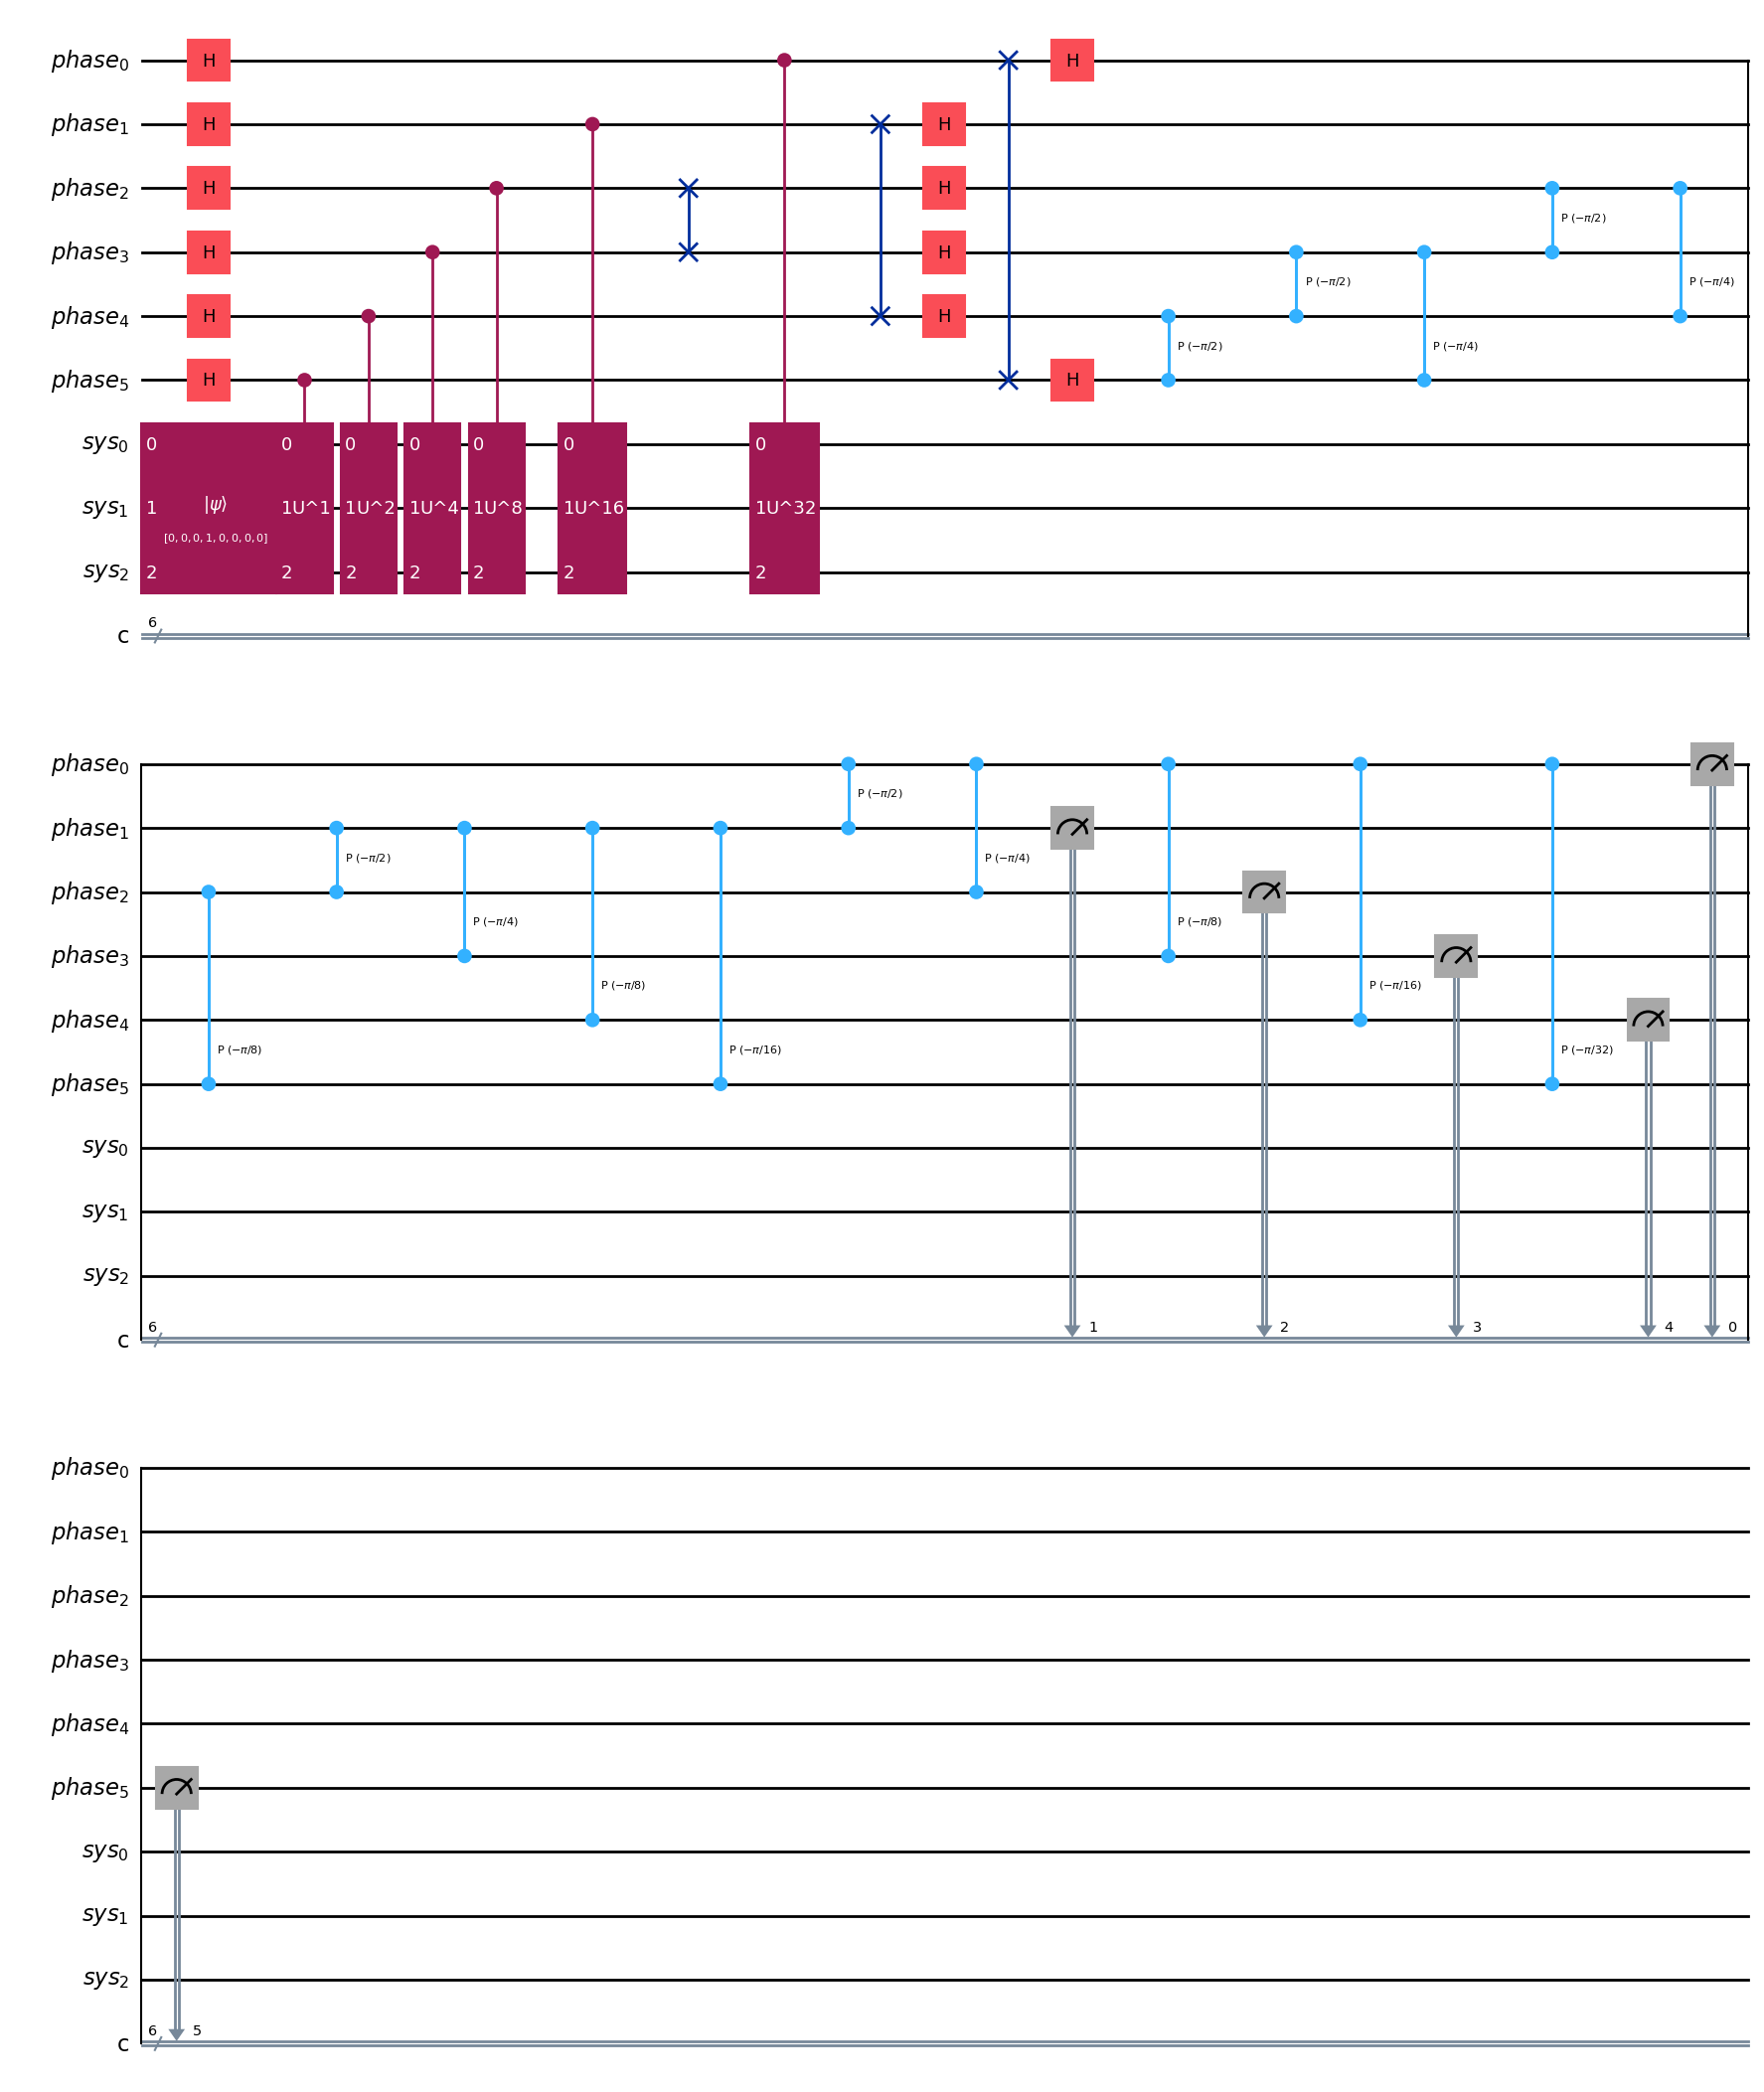

In [3]:
qc.draw("mpl")